In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
from sklearn import neighbors, metrics, cross_validation, grid_search, linear_model
import matplotlib.pyplot as plt
sns.set(style="whitegrid", font_scale=1)
%matplotlib inline

In [2]:
# URL to dataset
dataUrl = 'https://raw.githubusercontent.com/kug3lblitz/Heat-Replay/master/src/data/final/final.csv'

# Load the dataset
df = pd.read_csv(dataUrl)

In [3]:
# Check head
df.head(10)

,year,decade,unique_words,density,unique_words_raw,density_raw,nouns,verbs,adjectives,syllables,most_used_term,most_used_freq,curses,total_curses,reading_score,sentiment,charted
0,1961,1960,36,72,65,158,34,30,10,70,rose,7,0,0,2.367848,0.9885,0
1,1961,1960,45,91,74,197,45,37,19,81,name,6,0,0,2.771777,0.9712,1
2,1961,1960,54,103,88,223,45,48,17,98,babi,10,0,0,3.885650,0.9971,1
3,1961,1960,42,148,66,263,81,61,36,76,love,24,0,0,2.889886,0.9993,1
4,1961,1960,28,131,60,354,56,77,5,57,come,38,0,0,2.940000,0.9812,1
5,1961,1960,50,105,79,181,39,40,24,80,mari,13,0,0,3.135470,0.9789,1
6,1961,1960,39,75,70,160,28,35,21,81,take,13,0,0,3.503750,0.9978,1
7,1961,1960,50,94,78,190,62,17,8,83,never,6,0,0,3.074737,-0.9081,1
8,1961,1960,53,63,92,166,25,41,18,105,one,4,0,0,4.993855,0.2533,1
9,1961,1960,48,57,79,124,29,24,7,83,river,5,0,0,4.648387,-0.3400,1


In [4]:
# Basic descriptions of the distribution of the data
df.describe()

,year,decade,unique_words,density,unique_words_raw,density_raw,nouns,verbs,adjectives,syllables,most_used_freq,curses,total_curses,reading_score,sentiment,charted
count,3904.000000,3904.000000,3904.000000,3904.000000,3904.000000,3904.000000,3904.000000,3904.000000,3904.000000,3904.000000,3904.000000,3904.000000,3904.000000,3904.000000,3904.000000,3904.000000
mean,1991.199795,1986.552254,61.288166,137.016137,93.791496,292.182889,65.571209,64.231301,21.847336,105.648822,15.445184,0.175461,1.178023,4.874880,0.457047,0.580943
std,13.556839,13.559383,35.331564,80.208321,45.511645,168.326983,44.005934,42.659356,17.708684,56.066287,13.698001,0.380410,4.894722,3.527072,0.744473,0.493468
min,1961.000000,1960.000000,1.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,3.000000,1.000000,0.000000,0.000000,-3.427959,-0.999700,0.000000
25%,1981.000000,1980.000000,40.000000,84.000000,67.000000,181.000000,36.000000,34.000000,11.000000,72.000000,7.000000,0.000000,0.000000,2.975612,0.000000,0.000000
50%,1994.000000,1990.000000,53.000000,118.000000,85.000000,256.000000,54.000000,57.000000,17.000000,93.000000,12.000000,0.000000,0.000000,4.161161,0.927400,1.000000
75%,2003.000000,2000.000000,70.000000,165.000000,108.000000,355.000000,81.000000,84.000000,28.000000,121.000000,19.000000,0.000000,0.000000,5.747534,0.988400,1.000000
max,2010.000000,2010.000000,307.000000,638.000000,388.000000,1415.000000,376.000000,346.000000,205.000000,481.000000,234.000000,1.000000,88.000000,84.237399,0.999900,1.000000


In [5]:
df.drop(['most_used_term'], axis=1, inplace=True)

# Set features to use
features = list(df)
features.remove('charted')
features.remove('year')
features.remove('decade')

In [6]:

# Analyze Unnormalized and Normalized charted by sentiment

# Get group by counts for Unnormalized charted by sentiment
df_by_sentiment_unnorm = pd.DataFrame()
df_by_sentiment_unnorm['negative'] = df[df['sentiment'] <= 0]['charted'].value_counts()
df_by_sentiment_unnorm['positive'] = df[df['sentiment'] > 0]['charted'].value_counts()

# Get group by counts for Normalized charted by sentiment
df_by_sentiment_normed = pd.DataFrame()
df_by_sentiment_normed['negative'] = df[df['sentiment'] <= 0]['charted'].value_counts(normalize=True)
df_by_sentiment_normed['positive'] = df[df['sentiment'] > 0]['charted'].value_counts(normalize=True)

In [9]:
# Analyze Unnormalized and Normalized charted by sentiment

# Get group by counts for Unnormalized charted by sentiment
df_by_verbs_unnorm = pd.DataFrame()
df_by_verbs_unnorm['less than 40'] = df[df['verbs'] <= 40]['charted'].value_counts()
df_by_verbs_unnorm['more than 40'] = df[df['verbs'] > 40]['charted'].value_counts()

# Get group by counts for Normalized charted by sentiment
df_by_verbs_normed = pd.DataFrame()
df_by_verbs_normed['less than 40'] = df[df['verbs'] <= 40]['charted'].value_counts(normalize=True)
df_by_verbs_normed['more than 40'] = df[df['verbs'] > 40]['charted'].value_counts(normalize=True)

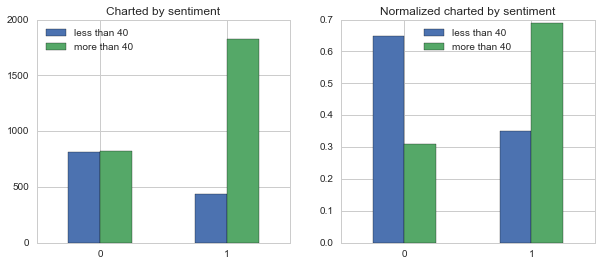

In [10]:
# Plot Unnormalized and Normalized charted by sentiment
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
df_by_verbs_unnorm.plot(ax=ax1, kind='bar', rot=0, title="Charted by sentiment")
ax2 = fig.add_subplot(122)
df_by_verbs_normed.plot(ax=ax2, kind='bar', rot=0, title="Normalized charted by sentiment")

In [11]:
# Set target variable name
target = 'charted'

# Set X and y
X = df.drop([target], axis=1)
y = df[target]

In [12]:
# Create separate training and test sets with 60/40 train/test split
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    X, y, test_size=0.4, random_state=42
)

In [13]:
# Instantiate logistic regression classifier using default params
lm = linear_model.LogisticRegression()

# Train logistic regression classifier on training set
lm.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [14]:
# Check model accuracy on test set
print "Accuracy: %0.3f" % lm.score(X_test, y_test)

Accuracy: 0.723


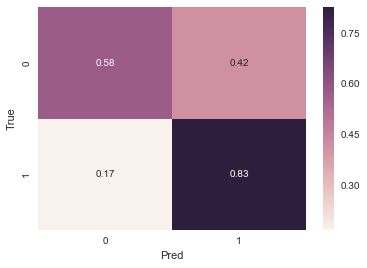

Confusion Matrix:
[[381 278]
 [154 749]]


In [15]:
# Get confusion matrix on test set
y_pred = lm.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

ax = plt.axes()
sns.heatmap(cm_normalized, annot=True)
ax.set_ylabel('True')
ax.set_xlabel('Pred')
plt.show()

print "Confusion Matrix:"
print cm

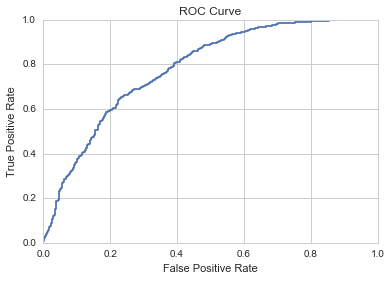

ROC AUC: 0.781


In [16]:
# Plot ROC curve and get AUC score
y_pred_proba = lm.predict_proba(X_test)[:,1]

# Determine the false positive and true positive rates
fpr, tpr, t = metrics.roc_curve(y_test, y_pred_proba)

 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

# Get ROC AUC score
print 'ROC AUC: %0.3f' % metrics.roc_auc_score(y_test, y_pred_proba)

In [17]:
# Set list of values to grid search over
c = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
s = ['newton-cg', 'lbfgs', 'liblinear', 'sag']
params = {'C': c, 'solver':s}

# Perform grid search using list of values
gs = grid_search.GridSearchCV(
    estimator=linear_model.LogisticRegression(),
    param_grid=params)
gs.fit(X_train, y_train)

# Get best value to use
print "Best Params:"
print gs.best_params_

# Get improvement
print "Accuracy of current model: %0.3f" % lm.score(X_test, y_test)
print "Accuracy using best param: %0.3f" % gs.best_score_

/home/sabbir/anaconda2/envs/venv/lib/python2.7/site-packages/scipy/optimize/linesearch.py:414: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/sabbir/anaconda2/envs/venv/lib/python2.7/site-packages/scipy/optimize/linesearch.py:285: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/sabbir/anaconda2/envs/venv/lib/python2.7/site-packages/sklearn/utils/optimize.py:200: UserWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
/home/sabbir/anaconda2/envs/venv/lib/python2.7/site-packages/sklearn/linear_model/sag.py:267: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Best Params:
{'C': 0.001, 'solver': 'newton-cg'}
Accuracy of current model: 0.723
Accuracy using best param: 0.812


In [18]:
# Current model params
print lm
print "Accuracy of current model: %0.3f" % lm.score(X_test, y_test)

# Update model params
lm.set_params(C=gs.best_params_['C'])
lm.set_params(solver=gs.best_params_['solver'])

# Retrain model on new params
lm.fit(X_train, y_train)

# Updated model params
print lm
print "Accuracy of updated model: %0.3f" % lm.score(X_test, y_test)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of current model: 0.723
LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of updated model: 0.808


In [19]:
# URL to dataset
dataUrl = 'https://raw.githubusercontent.com/kug3lblitz/Heat-Replay/master/src/data/final/final.csv'

# Load the dataset
df_train = pd.read_csv(dataUrl)
df_train.drop(['most_used_term'], axis=1, inplace=True)

In [20]:
# Set target variable name
target = 'charted'

# Set X_train and y_train
X_train = df_train.drop([target], axis=1)
y_train = df_train[target]

In [21]:
# Build tuned model
lm = linear_model.LogisticRegression(
    C=gs.best_params_['C'], class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver=gs.best_params_['solver'], tol=0.0001,
          verbose=0, warm_start=False
)

# Train tuned model
lm.fit(X_train, y_train)

# Score tuned model
print "Accuracy: %0.3f" % lm.score(X_train, y_train)

Accuracy: 0.812


In [22]:
# Generate probabililty of survivial using trained model
df_train['Probability'] = lm.predict_proba(X_train)[:,1]

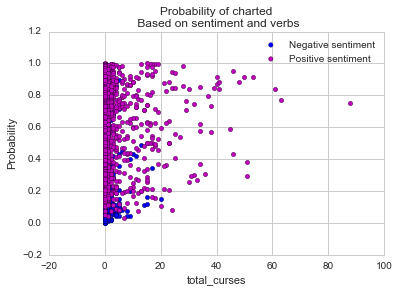

In [29]:
# Plot Probability of charted based on verbs and...
ax = df_train[df_train['verbs'] <= 50].plot(
    x='total_curses', y='Probability', kind='scatter', color='b', label='Negative sentiment'
)

df_train[df_train['verbs'] > 50].plot(
    ax=ax, x='total_curses', y='Probability', kind='scatter', color='m', label='Positive sentiment'
)
ax.set(title='Probability of charted\n Based on sentiment and verbs')

In [ ]:
# Plot Probability of Survivial Based on Pclass and Age
sns.lmplot(x="sentiment", y="Probability", hue="verbs", data=df_train)

In [ ]:
# set list of values to grid search over
k = range(2, 100)
params = {'n_neighbors': k }

#set inputs
X = df[['reading_score', 'sentiment']]
y = df['charted'].tolist()

# perform grid search using list of values
kf = cross_validation.KFold(len(df), n_folds = 5)
gs = grid_search.GridSearchCV(
    estimator=neighbors.KNeighborsClassifier(),
    param_grid=params,
    cv=kf)
gs.fit(X, y)

# get best value to use
print gs.best_estimator_

In [ ]:
# plot search values vs. grid scores
plt.plot(k, [s[1] for s in gs.grid_scores_])

In [ ]:
# Set target variable name
target = 'charted'

# Set X and y
X = df.drop([target], axis=1)
y = df[target]

# train knn classifier using default params
knn = neighbors.KNeighborsClassifier(
        algorithm='auto', leaf_size=30, metric='minkowski',metric_params=None,
        n_jobs=1, n_neighbors=62, p=2, weights='uniform'
)

knn.fit(X, y)

# use knn classifier to make predictions
predictions = knn.predict(X)
df['predictions'] = predictions
print predictions

# calculate accuracy of improved classifier
accuracy = knn.score(X, y)
print "Accuracy: " + str(accuracy)

# apply a color map across the improved predicted species and plot
cmap = {'0': 'r', '1': 'g', '2': 'b' }
df['cpredictions'] = df.predictions.apply(lambda x: cmap[str(x)])
df.plot('reading_score', 'sentiment', kind='scatter', c=df.cpredictions)

In [ ]:
from sklearn import tree

# Set features to use
features = list(df)
features.remove('charted')
features.remove('year')
features.remove('decade')

print features

# Set target variable name
target = 'charted'

# Set X and y
X = df[features]
y = df[target]

# Create separate training and test sets with 60/40 train/test split
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    X, y, test_size=0.4, random_state=42
)

# Instantiate model using default params
tm = tree.DecisionTreeClassifier()

# Train model on training set
tm.fit(X_train, y_train)

# Evaluate accuracy of model on test set
print "Accuracy: %0.3f" % tm.score(X_test, y_test)

# Evaluate ROC AUC score of model on test set
print 'ROC AUC: %0.3f' % metrics.roc_auc_score(y_test, tm.predict_proba(X_test)[:,1])

In [ ]:
# Get confusion matrix on test set
y_pred = tm.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

ax = plt.axes()
sns.heatmap(cm_normalized, annot=True)
ax.set_ylabel('True')
ax.set_xlabel('Pred')
plt.show()

print "Confusion Matrix:"
print cm

In [ ]:
# Evaluate model on train set
print "Accuracy: %0.3f" % tm.score(X_train, y_train)

# Evaluate model on test set
print "Accuracy: %0.3f" % tm.score(X_test, y_test)

In [ ]:
# Instantiate model using default params
tm = tree.DecisionTreeClassifier(max_depth=2, min_samples_leaf=5)

# Train model on training set
tm.fit(X_train, y_train)

In [ ]:
# Evaluate model on train set
print "Accuracy: %0.3f" % tm.score(X_train, y_train)

# Evaluate model on test set
print "Accuracy: %0.3f" % tm.score(X_test, y_test)

# Random Forests

In [ ]:
from sklearn import ensemble

# Instantiate model
rf = ensemble.RandomForestClassifier(n_estimators=20)

# Train model on training set
rf.fit(X_train, y_train)

In [ ]:
# Evaluate model on train set
print "Accuracy: %0.3f" % tm.score(X_train, y_train)

# Evaluate model on test set
print "Accuracy: %0.3f" % tm.score(X_test, y_test)

In [15]:
# Set list of values to grid search over
n = [500, 1000]
params = {'n_estimators': n}

# Perform grid search using list of values
gs = grid_search.GridSearchCV(
    estimator=ensemble.RandomForestClassifier(),
    param_grid=params)
gs.fit(X_train, y_train)

# Get best value to use
print "Best Params:"
print gs.best_params_

# Get improvement
print "Accuracy of current model: %0.3f" % rf.score(X_test, y_test)
print "Accuracy using best param: %0.3f" % gs.best_score_

# Plot scores
plt.plot(n, [s[1] for s in gs.grid_scores_])



# Current model params
print rf
print "Accuracy of current model: %0.3f" % rf.score(X_test, y_test)

# Update model params
rf.set_params(n_estimators=gs.best_params_['n_estimators'])

# Retrain model on new params
rf.fit(X_train, y_train)

# Updated model params
print rf
print "Accuracy of updated model: %0.3f" % rf.score(X_test, y_test)

NameError: name 'ensemble' is not defined

In [ ]:
# Plot importances for all features
features = X.columns
feature_importances = rf.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

sns.barplot(y='Features', x='Importance Score', data=features_df)